Created on Mon Dec 01 15:05:56 2016
@author: Richard

##### Required packages:
* pySTATIS
* numpy
* mapalign
* nibabel
* sklearn
* cluster_roi

##### suggested file struture:
* main/
* main/cpac/filt_noglobal/rois_cc400/ > for data files
* main/Affn/ > for adjacency matrices
* main/Embs/ > for diffusion embedding files

##### download ABIDE data:
http://preprocessed-connectomes-project.org/abide/download.html

python download_abide_preproc.py -d rois_cc400 -p cpac -s filt_noglobal -o data/ -x 'M' -gt 18 -lt 55

In [2]:
## lets start with some actual script
# import useful things
import numpy as np
import os
import nibabel as nib
from sklearn.metrics import pairwise_distances

# get a list of inputs
from os import listdir
from os.path import isfile, join

# little helper function to return the proper filelist with the full path
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in listdir_nohidden(d)]
# and create a filelist
onlyfiles = listdir_fullpath("data/Outputs/cpac/filt_noglobal/rois_cc400")

Check all files to see if any have missing nodal information and create a selection list based on the ones that are 100% complete.

In [5]:
# check to see which files contains nodes with missing information
missingarray = []
for i in onlyfiles:
# load timeseries
    filename = i
    ts_raw = np.loadtxt(filename)

# check zero columns
    missingn = np.where(~ts_raw.any(axis=0))[0]
    missingarray.append(missingn)

# select the ones that don't have missing data
ids = np.where([len(i) == 0 for i in missingarray])[0]
selected = [onlyfiles[i] for i in ids]
# could be useful to have one without pathnames later one
selected2 = [os.path.basename(onlyfiles[i]) for i in ids]
print(len(selected))

178


### run the diffusion embedding

In [14]:
# run the diffusion embedding
from mapalign import embed

for i in selected:
    # load timeseries
    print i
    filename = i
    ts = np.loadtxt(filename)
    # create correlation matrix
    dcon = np.corrcoef(ts.T)
    dcon[np.isnan(dcon)] = 0

    # Get number of nodes
    N = dcon.shape[0]

    # threshold
    perc = np.array([np.percentile(x, 90) for x in dcon])

    for ii in range(dcon.shape[0]):
        #print "Row %d" % ii
        dcon[ii, dcon[ii,:] < perc[ii]] = 0

    # If there are any left then set them to zero
    dcon[dcon < 0] = 0

    # compute the pairwise correctionlation distances
    aff = 1 - pairwise_distances(dcon, metric = 'cosine')

    # start saving
    savename = os.path.basename(filename)
    np.save("./data/Outputs/Affn/"+savename+"_cosine_affinity.npy", aff)
    # get the diffusion maps
    emb, res = embed.compute_diffusion_map(aff, alpha = 0.5)
    # Save results
    np.save("./data/Outputs/Embs/"+savename+"_embedding_dense_emb.npy", emb)
    np.save("./data/Outputs/Embs/"+savename+"_embedding_dense_res.npy", res)

    X = res['vectors']
    X = (X.T/X[:,0]).T[:,1:]    
    
    np.save("./data/Outputs/Embs/"+savename+"_embedding_dense_res_veconly.npy", X) #store vectors only

data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051465_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051474_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051476_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051477_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051488_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Caltech_0051492_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/CMU_a_0050649_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050682_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050683_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050685_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050686_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050688_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuven_1_0050689_rois_cc400.1D
data/Outputs/cpac/filt_noglobal/rois_cc400/Leuv

Run Statis to back-project the grouped embeddings

In [17]:
from pySTATIS import statis

#load vectors
names = list(xrange(392))
X = [np.load("./data/Outputs/Embs/"+ os.path.basename(filename)+"_embedding_dense_res_veconly.npy") for filename in selected2]
out = statis.statis(X, names, fname='statis_results.npy')
statis.project_back(X, out['Q'], path = "./data/Outputs/Regs/",fnames = selected2)
np.save("Mean_Vec.npy",out['F'])

Normalizing tables...
Not performing any manipulations on input matrices
Stacking matrices horizontally...
Getting masses for rows and weights for columns...
Computing Z...
Computing C...
Decomposing similarity matrix...
Performing GSVD on the horizontally concatenated matrix...
Calculating contributions of rows, columns and tables...
File already exists for subject 0
File already exists for subject 1
File already exists for subject 2
File already exists for subject 3
File already exists for subject 4
File already exists for subject 5
File already exists for subject 6
File already exists for subject 7
File already exists for subject 8
File already exists for subject 9
File already exists for subject 10
File already exists for subject 11
File already exists for subject 12
File already exists for subject 13
File already exists for subject 14
File already exists for subject 15
File already exists for subject 16
File already exists for subject 17
File already exists for subject 18
File alr

In [ ]:
# saving everything in one dump
import pickle
with open('output.pickle' ,'w') as f:
    pickle.dump([selected, out],f)

#### plotting 
plot to surface for inspection
this cell in only necessary for plotting below

In [3]:
import matplotlib.pylab as plt
import nilearn
import nilearn.plotting

import numpy as np
import nibabel as nib

def rebuild_nii(num):

    data = np.load('Mean_Vec.npy')
    a = data[:,num].copy()
    nim = nib.load('cc400_roi_atlas.nii')
    imdat=nim.get_data()
    imdat_new = imdat.copy()

    for n, i in enumerate(np.unique(imdat)):
        if i != 0:
            imdat_new[imdat == i] = a[n-1] * 100000 # scaling factor. Could also try to get float values in nifti...

    nim_out = nib.Nifti1Image(imdat_new, nim.get_affine(), nim.get_header())
    nim_out.set_data_dtype('float32')
    # to save:
    nim_out.to_filename('Gradient_'+ str(num) +'_res.nii')

    nilearn.plotting.plot_epi(nim_out)
    return(nim_out)

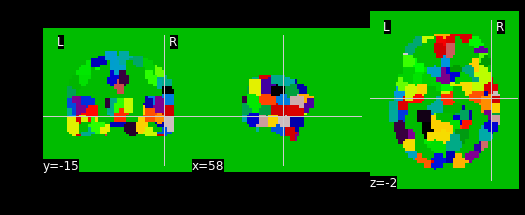

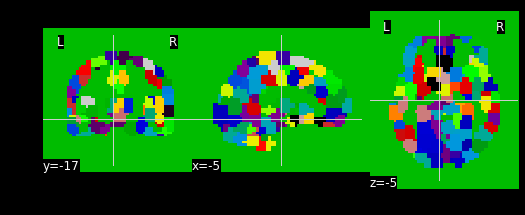

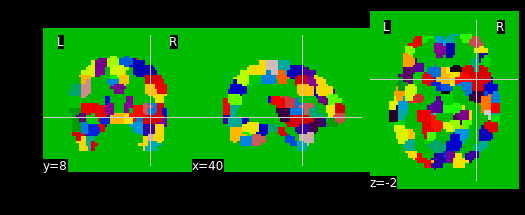

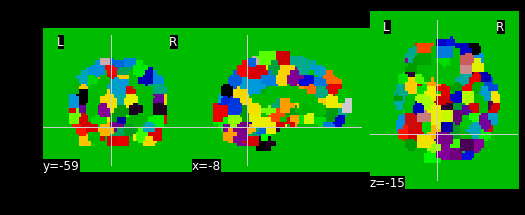

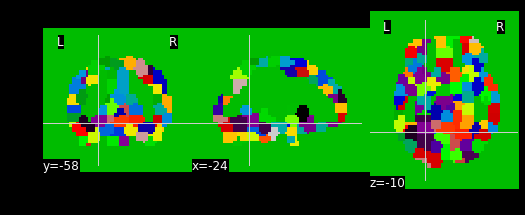

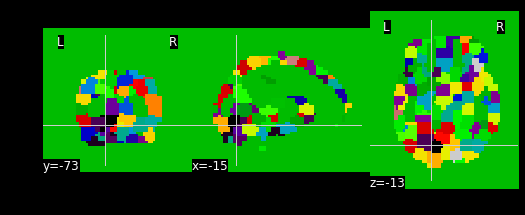

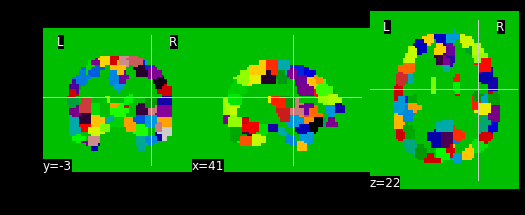

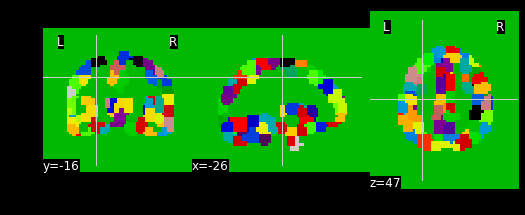

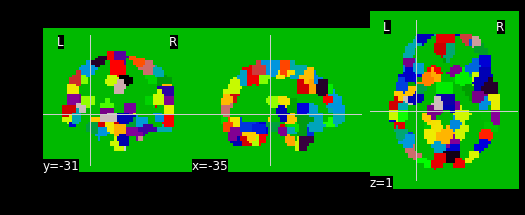

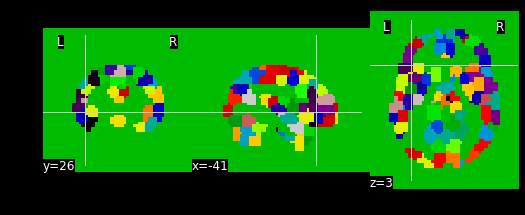

In [12]:
for i in range(10):
    nims = rebuild_nii(i)

Output everything to an excel file

In [6]:
import pandas as pd
# read in csv
df_phen = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')
# add a column that matches the filename
for i in df_phen:
    df_phen['filename'] = join(df_phen['FILE_ID']+"_rois_cc400.1D")
    df_phen['filenamelpy'] = join(df_phen['FILE_ID']+"_rois_cc400.1D.npy")

df_phen['selec'] = np.where(df_phen['filename'].isin((selected2)), 1, 0)

Compare the slopes across subjects

In [7]:
from scipy import stats
grdnt_slope = []
for i in selected2:
    # load gradients
    print i
    filename = i
    grdnt = np.load("./data/Outputs/Regs/" + filename + ".npy")
    # do we need a specific ordering of the nodes??
    y = list(xrange(392))
    temp = []
    for ii in range(10):
        x = sorted(grdnt[:,ii]) # just sort in ascending order?
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        temp.append(slope)
        
    grdnt_slope.append(temp)
grdnt_slope = np.array(grdnt_slope)
# make it into a dataframe
data_grdnt = pd.DataFrame(grdnt_slope)
data_grdnt['file'] = selected2

Caltech_0051465_rois_cc400.1D
Caltech_0051474_rois_cc400.1D
Caltech_0051476_rois_cc400.1D
Caltech_0051477_rois_cc400.1D
Caltech_0051488_rois_cc400.1D
Caltech_0051492_rois_cc400.1D
CMU_a_0050649_rois_cc400.1D
Leuven_1_0050682_rois_cc400.1D
Leuven_1_0050683_rois_cc400.1D
Leuven_1_0050685_rois_cc400.1D
Leuven_1_0050686_rois_cc400.1D
Leuven_1_0050688_rois_cc400.1D
Leuven_1_0050689_rois_cc400.1D
Leuven_1_0050690_rois_cc400.1D
Leuven_1_0050691_rois_cc400.1D
Leuven_1_0050692_rois_cc400.1D
Leuven_1_0050694_rois_cc400.1D
Leuven_1_0050695_rois_cc400.1D
Leuven_1_0050696_rois_cc400.1D
Leuven_1_0050697_rois_cc400.1D
Leuven_1_0050698_rois_cc400.1D
Leuven_1_0050699_rois_cc400.1D
Leuven_1_0050700_rois_cc400.1D
Leuven_1_0050703_rois_cc400.1D
Leuven_1_0050704_rois_cc400.1D
Leuven_1_0050705_rois_cc400.1D
Leuven_1_0050706_rois_cc400.1D
Leuven_1_0050707_rois_cc400.1D
Leuven_1_0050708_rois_cc400.1D
Leuven_1_0050709_rois_cc400.1D
Leuven_1_0050710_rois_cc400.1D
MaxMun_a_0051318_rois_cc400.1D
MaxMun_a_0051319_

And write them to an excel file

In [8]:
data = df_phen.loc[df_phen["selec"] == 1]
data['filenamelow'] = data['filename'].str.lower()
data = data.sort(['filenamelow'])

output = data.merge(data_grdnt, left_on='filename',right_on='file',how='outer')
output.to_csv('Combined.csv', sep='\t')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [9]:
output

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,1,2,3,4,5,6,7,8,9,file
0,1051,1052,51465,1052,51465,CALTECH,Caltech_0051465,1,1,20.2000,...,111.053962,120.432610,108.125877,110.138515,103.955927,112.065186,102.348089,95.813187,101.079457,Caltech_0051465_rois_cc400.1D
1,1060,1061,51474,1061,51474,CALTECH,Caltech_0051474,1,1,20.9000,...,112.398943,127.939731,117.771059,116.258446,109.719219,127.164099,112.449931,103.937734,128.203298,Caltech_0051474_rois_cc400.1D
2,1062,1063,51476,1063,51476,CALTECH,Caltech_0051476,2,0,39.3000,...,110.546209,110.759956,118.037661,119.409824,114.219359,110.435416,159.094646,135.745460,120.451261,Caltech_0051476_rois_cc400.1D
3,1063,1064,51477,1064,51477,CALTECH,Caltech_0051477,2,0,42.5000,...,118.750349,115.343000,109.970308,118.519871,121.917658,115.753359,110.591986,175.994220,123.659119,Caltech_0051477_rois_cc400.1D
4,1074,1075,51488,1075,51488,CALTECH,Caltech_0051488,2,0,23.3000,...,109.830617,117.942158,112.688097,117.640278,118.433831,115.821046,121.335436,147.532282,104.286702,Caltech_0051488_rois_cc400.1D
5,1078,1079,51492,1079,51492,CALTECH,Caltech_0051492,2,0,18.7000,...,103.356001,114.267606,107.626892,105.993916,110.191987,110.221059,99.191943,112.487443,118.389674,Caltech_0051492_rois_cc400.1D
6,504,505,50649,505,50649,CMU,CMU_a_0050649,1,1,22.0000,...,101.465229,104.348597,102.711102,102.242866,106.967664,110.047941,87.275930,109.066389,103.000939,CMU_a_0050649_rois_cc400.1D
7,524,525,50682,525,50682,LEUVEN_1,Leuven_1_0050682,2,0,23.0000,...,113.407135,116.957856,108.839389,108.446136,113.742015,119.911026,106.278675,113.942607,125.219382,Leuven_1_0050682_rois_cc400.1D
8,525,526,50683,526,50683,LEUVEN_1,Leuven_1_0050683,2,0,24.0000,...,113.397636,114.630715,104.493566,111.327372,121.483412,117.436233,105.798883,120.424970,109.710475,Leuven_1_0050683_rois_cc400.1D
9,526,527,50685,527,50685,LEUVEN_1,Leuven_1_0050685,2,0,23.0000,...,113.612352,106.803404,114.222598,109.737362,107.982712,119.321610,94.499295,100.023425,91.898787,Leuven_1_0050685_rois_cc400.1D


In [13]:
output[['DX_GROUP','1']]

KeyError: "['1'] not in index"

In [ ]:
## numpy is used for creating fake data
import numpy as np 
import matplotlib as mpl 

## agg backend is used to create plot as a .png file
mpl.use('agg')

import matplotlib.pyplot as plt 

group1 = pd.output

## combine the groups collections into a list    
data_to_plot = [group1, group2]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

Some quality control

In [2]:
%matplotlib inline
# this cell in only necessary for plotting below
import matplotlib.pylab as plt 
import nilearn 
import nilearn.plotting 

import numpy as np
import nibabel as nib
from os import listdir
from os.path import isfile, join

def rebuild_nii(num):
    
    data = np.load('Mean_Vec.npy')
    a = data[:,num].copy()
    nim = nib.load('cc400_roi_atlas.nii')
    imdat=nim.get_data()
    imdat_new = imdat.copy()

    for n, i in enumerate(np.unique(imdat)):
        if i != 0:
            imdat_new[imdat == i] = a[n-1] * 100000 # scaling factor. Could also try to get float values in nifti...

    nim_out = nib.Nifti1Image(imdat_new, nim.get_affine(), nim.get_header())
    nim_out.set_data_dtype('float32')
    # to save:
    # nim_out.to_filename('res.nii')

    nilearn.plotting.plot_epi(nim_out)

def rebuild_nii_individ(num):
    
    onlyfiles = [f for f in listdir_nohidden('./data/Outputs/Regs/') if isfile(join('./data/Outputs/Regs/', f))]

    for sub in onlyfiles:

        data = np.load('./data/Outputs/Regs/%s' % sub)
        a = data[:,num].copy()
        nim = nib.load('cc400_roi_atlas.nii')
        imdat=nim.get_data()
        imdat_new = imdat.copy()

        for n, i in enumerate(np.unique(imdat)):
            if i != 0:
                imdat_new[imdat == i] = a[n-1] * 10 # scaling factor. Could also try to get float values in nifti...

        nim_out = nib.Nifti1Image(imdat_new, nim.get_affine(), nim.get_header())
        nim_out.set_data_dtype('float32')
        # to save:
        # nim_out.to_filename('res.nii')
        nilearn.plotting.plot_epi(nim_out, cut_coords=(0,0,0))

Check all individual images

//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


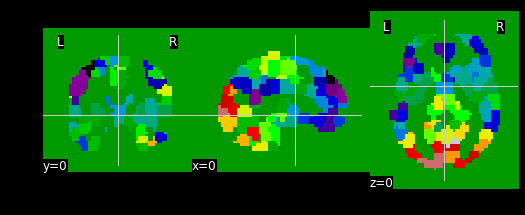

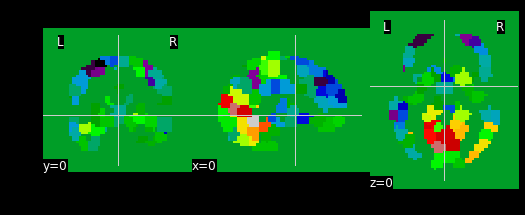

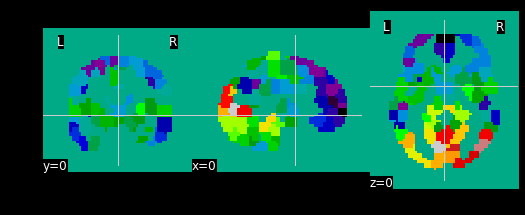

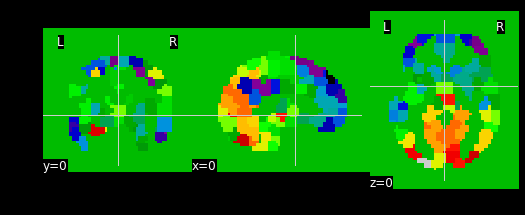

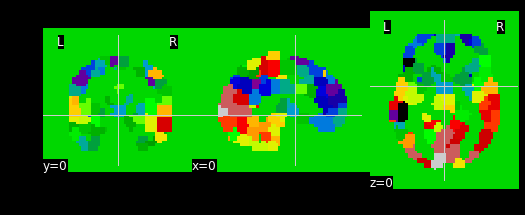

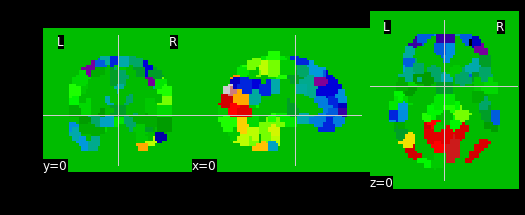

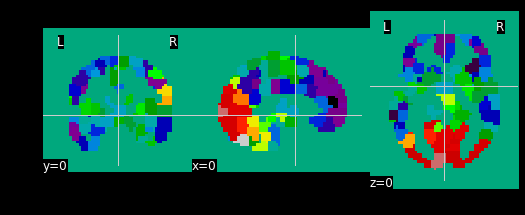

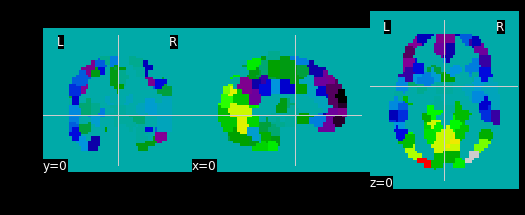

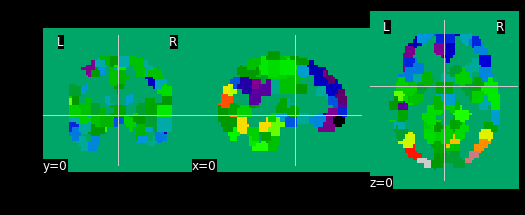

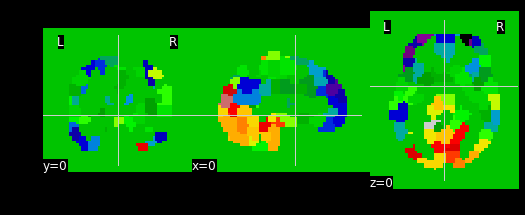

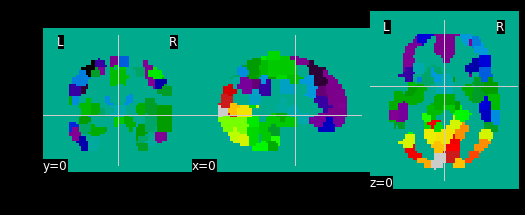

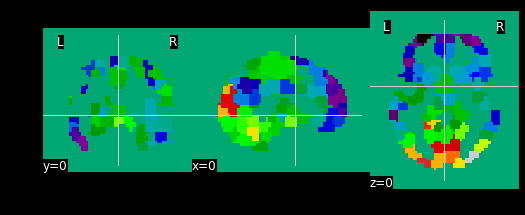

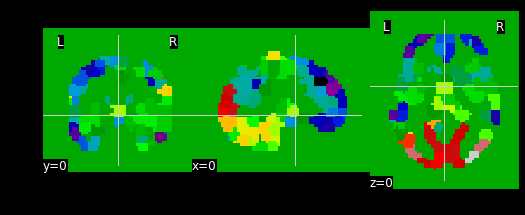

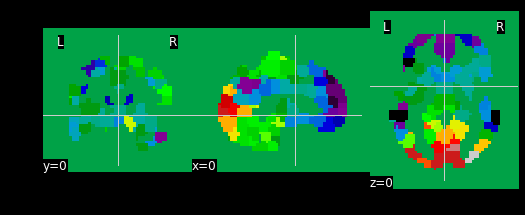

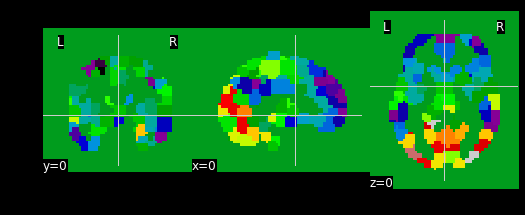

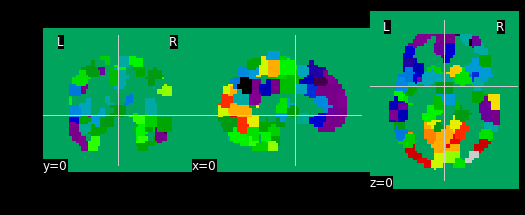

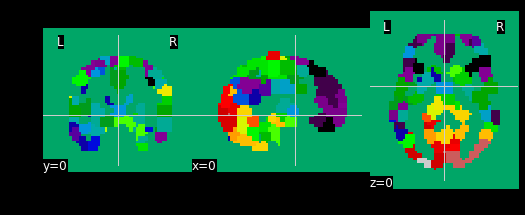

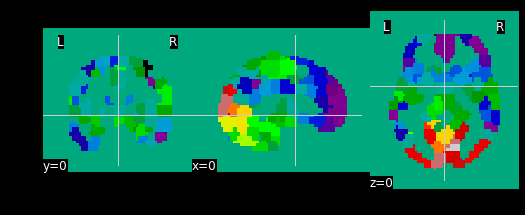

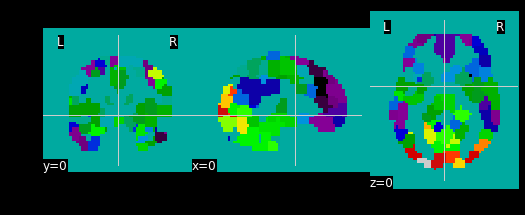

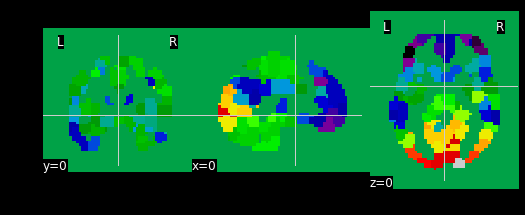

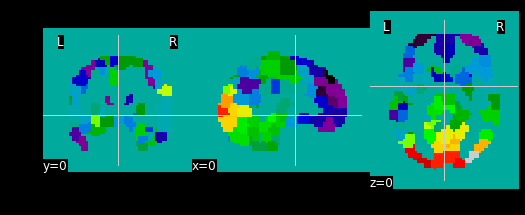

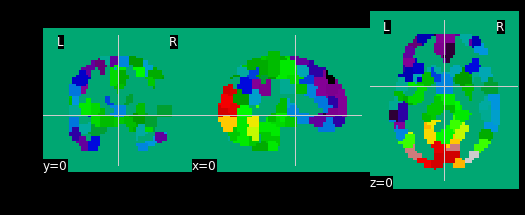

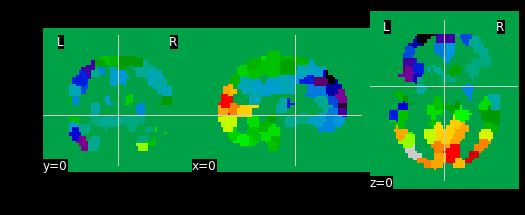

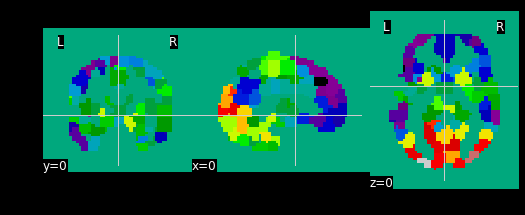

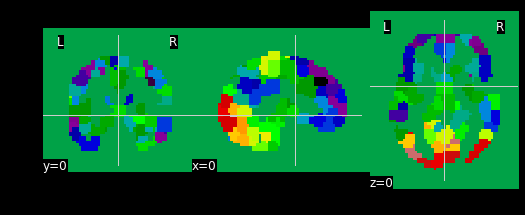

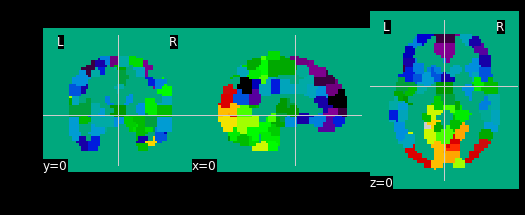

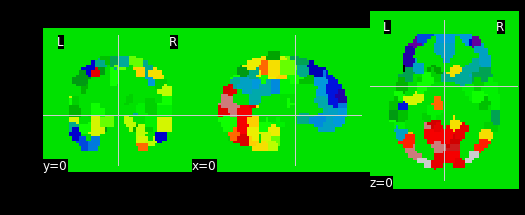

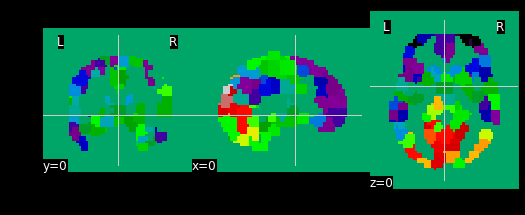

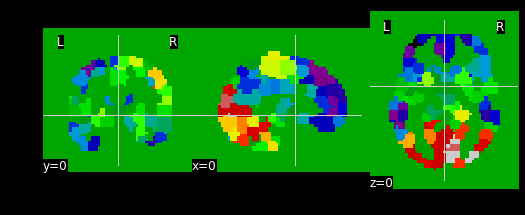

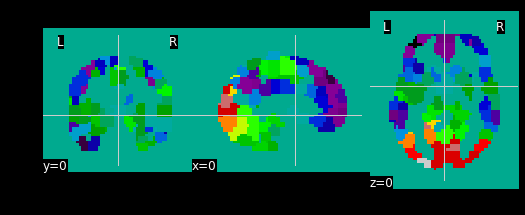

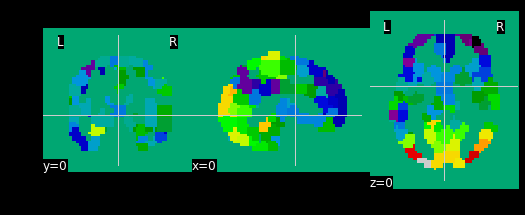

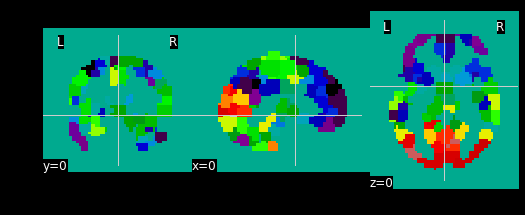

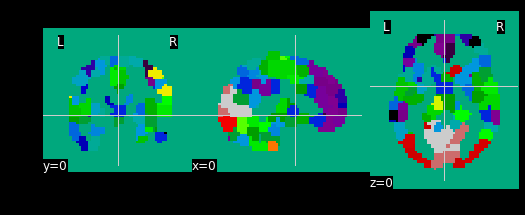

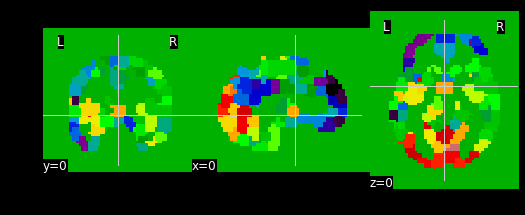

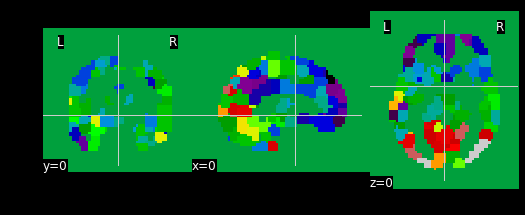

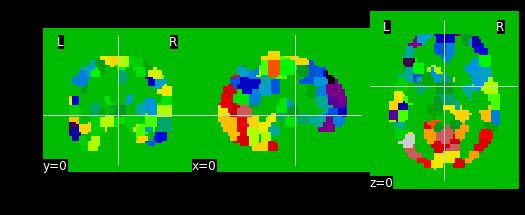

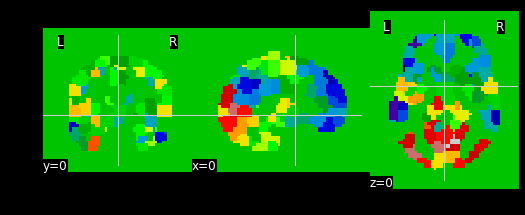

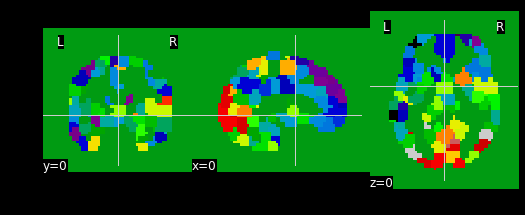

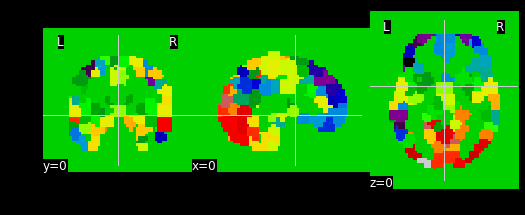

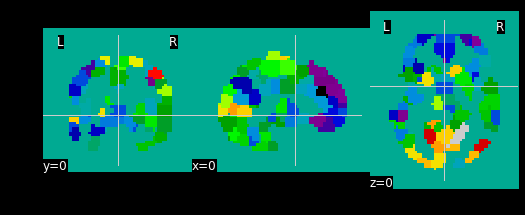

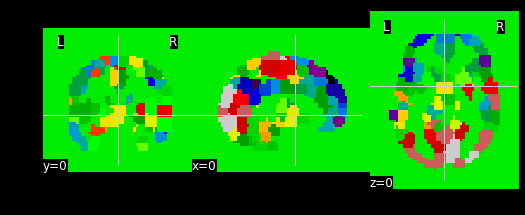

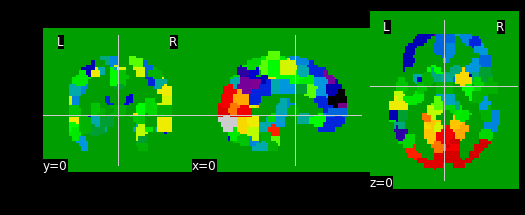

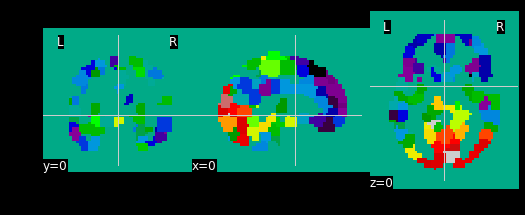

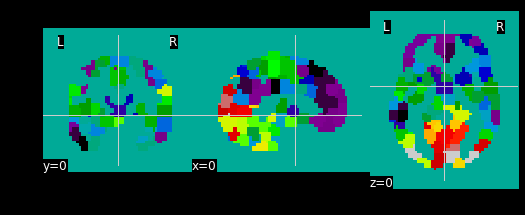

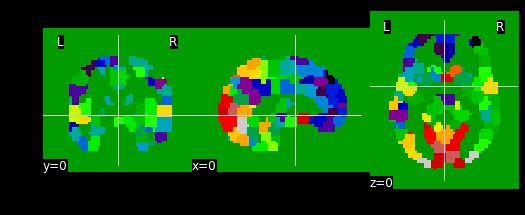

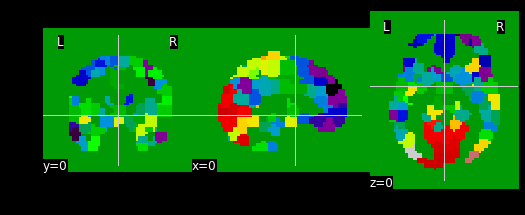

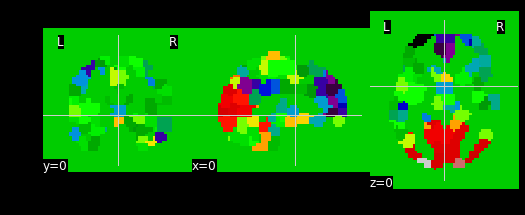

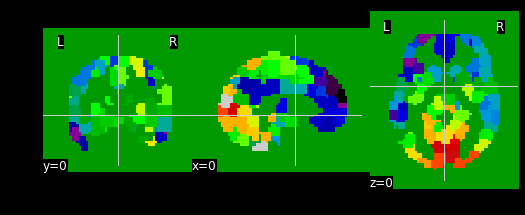

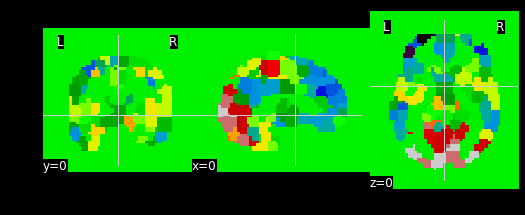

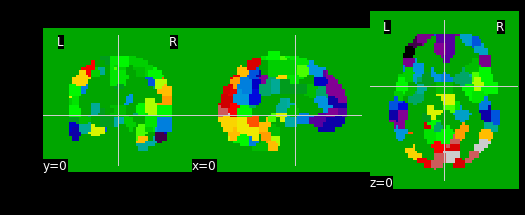

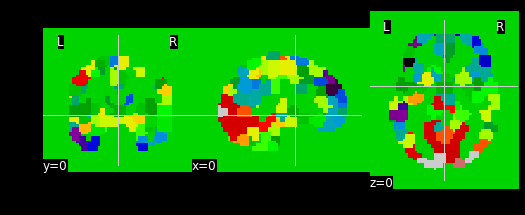

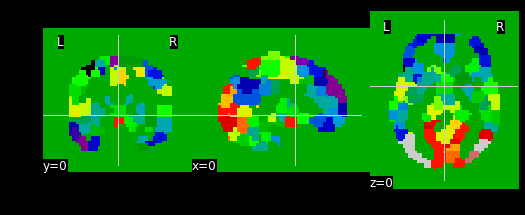

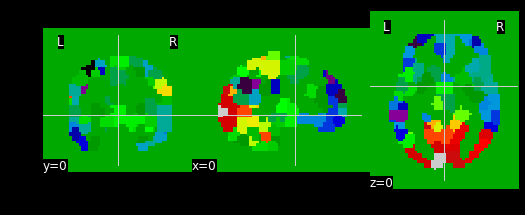

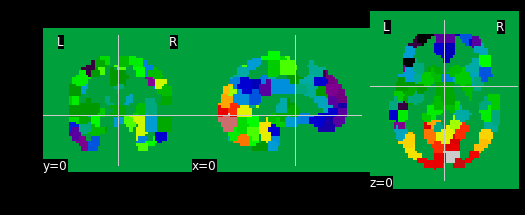

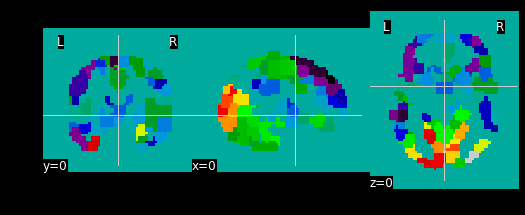

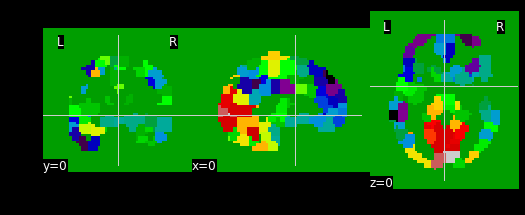

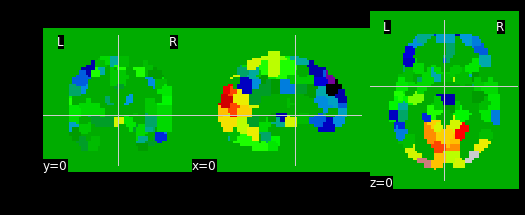

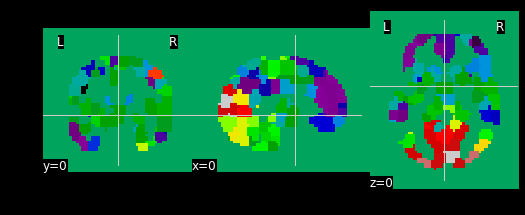

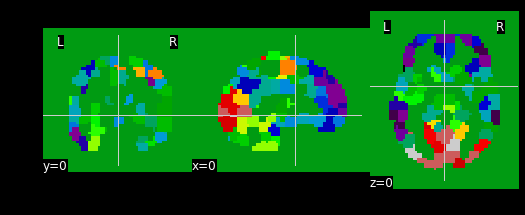

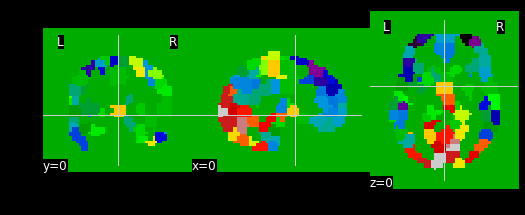

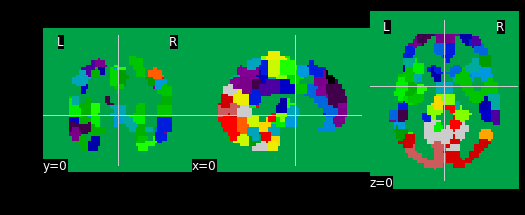

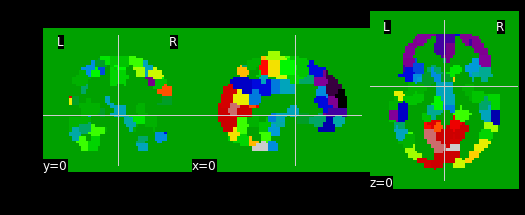

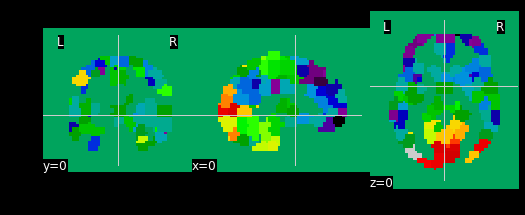

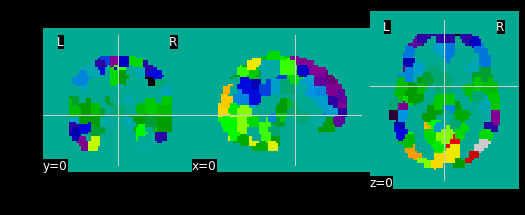

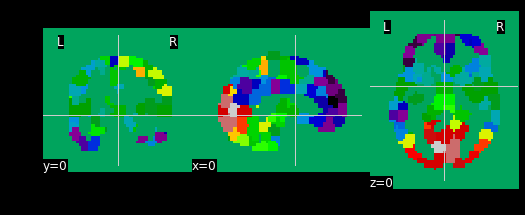

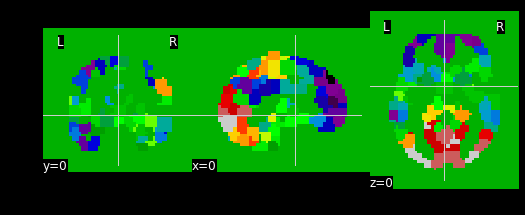

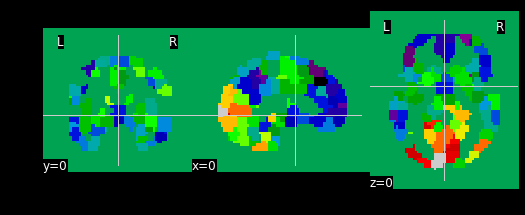

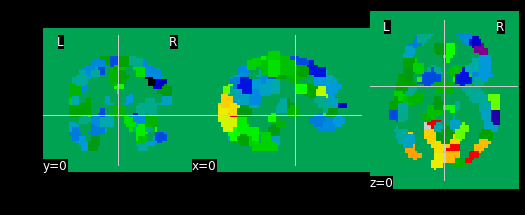

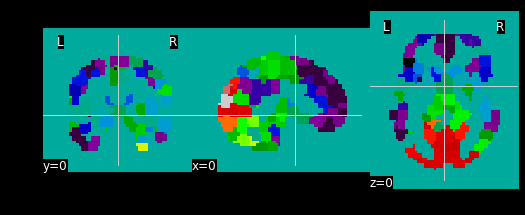

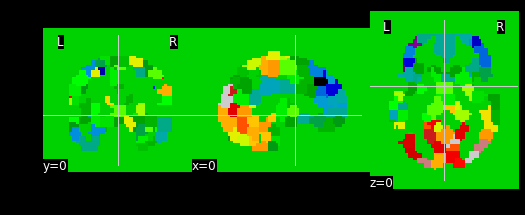

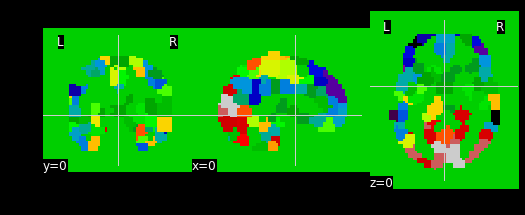

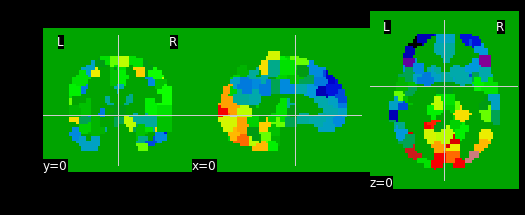

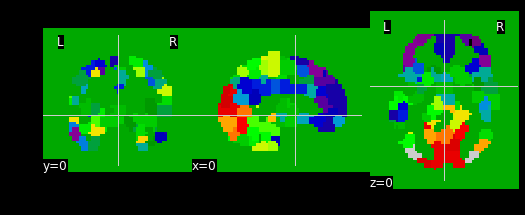

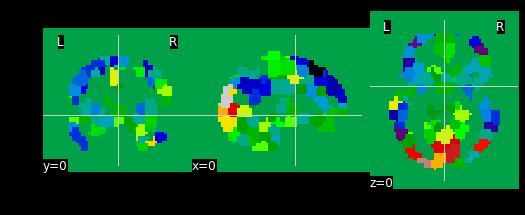

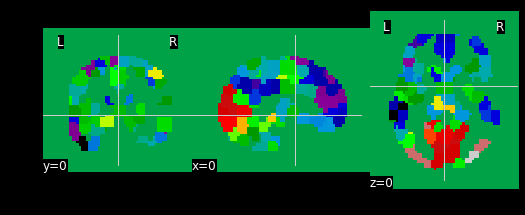

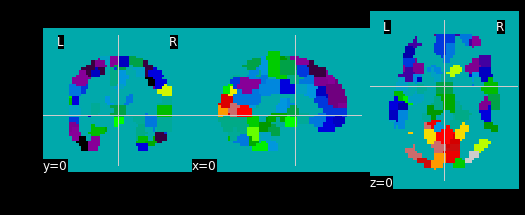

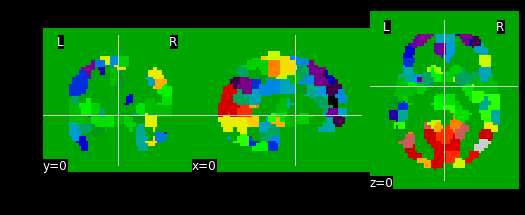

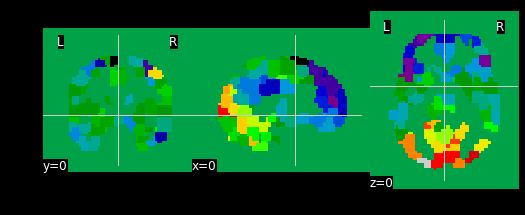

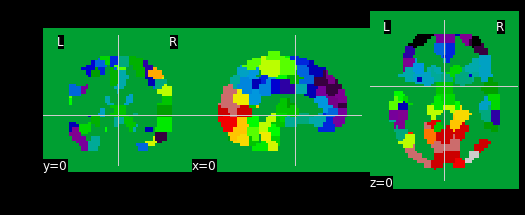

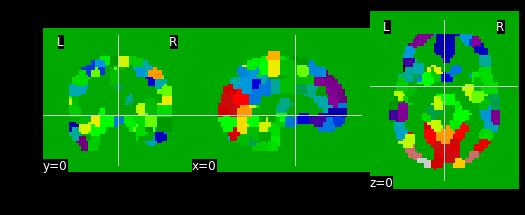

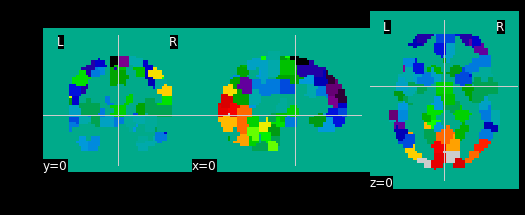

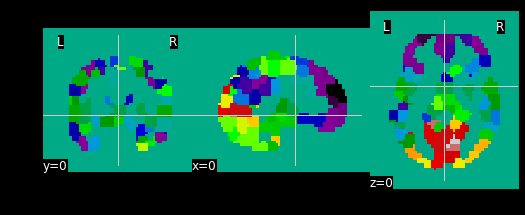

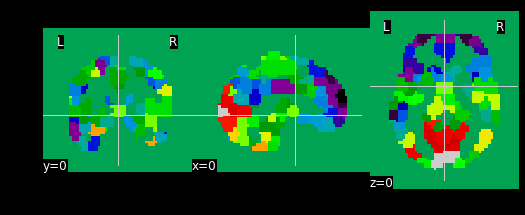

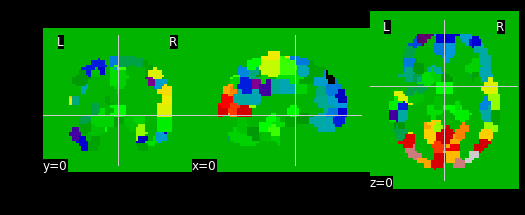

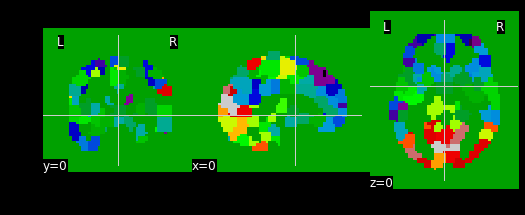

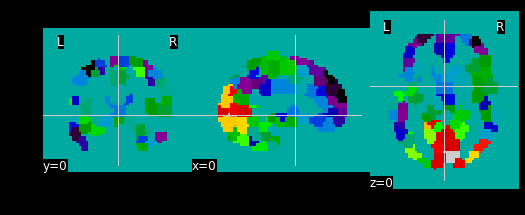

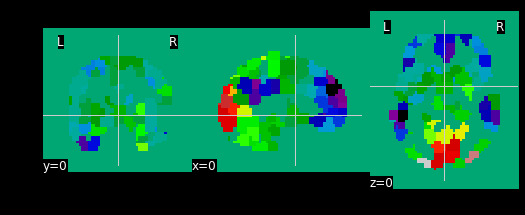

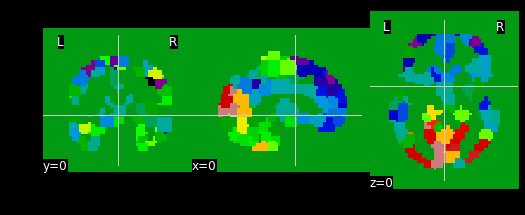

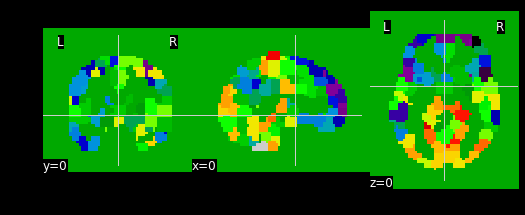

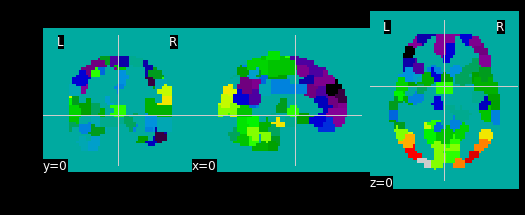

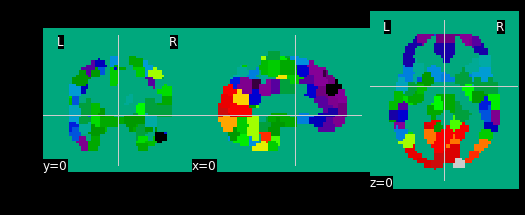

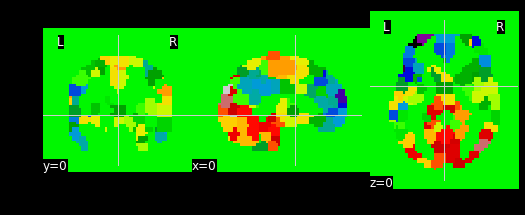

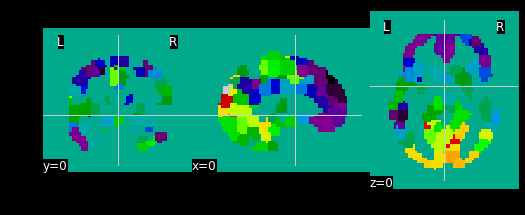

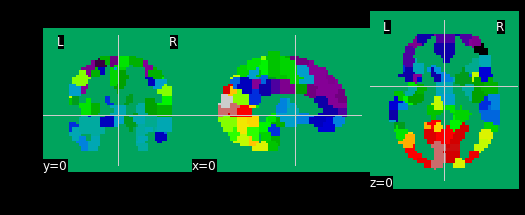

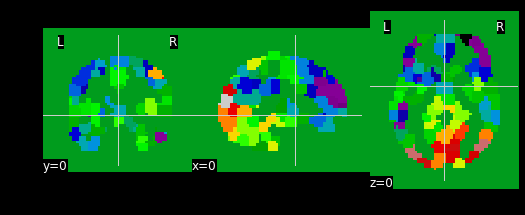

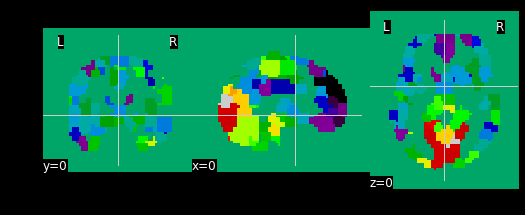

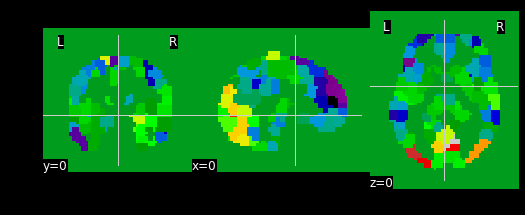

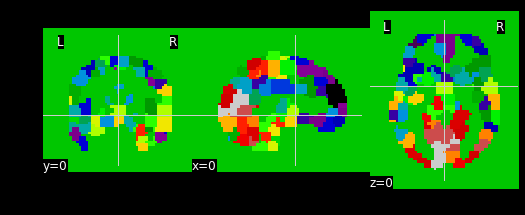

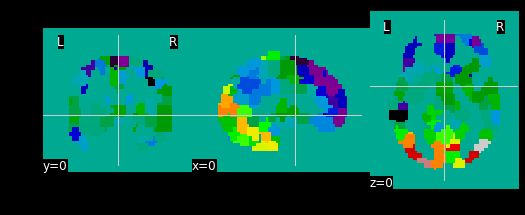

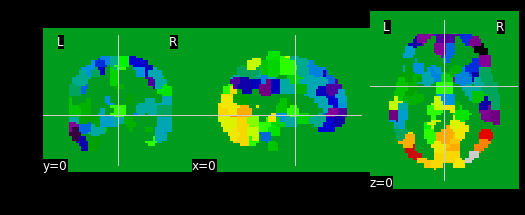

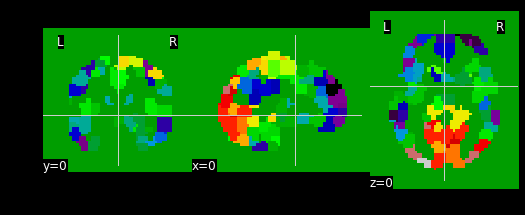

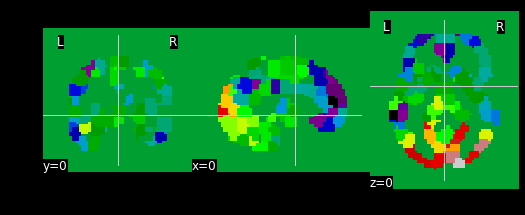

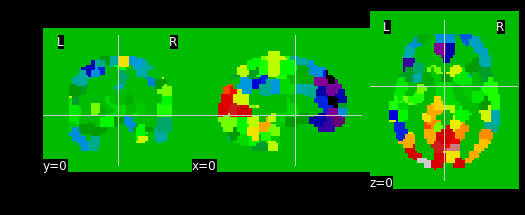

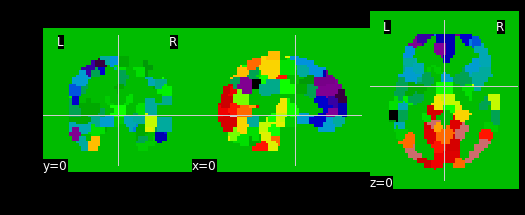

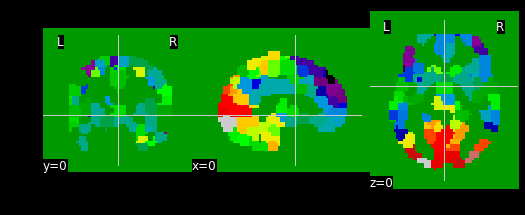

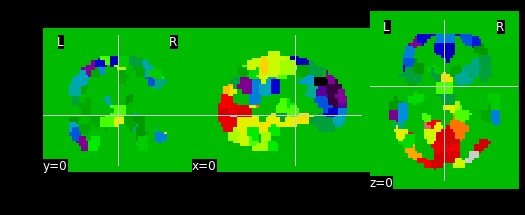

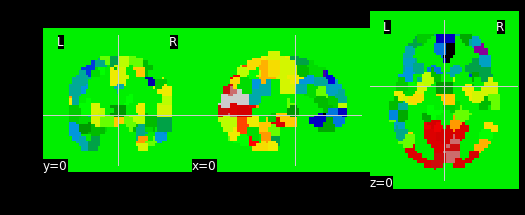

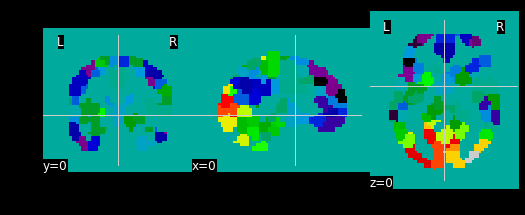

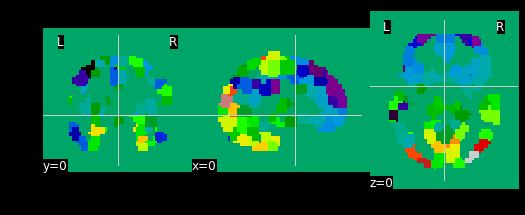

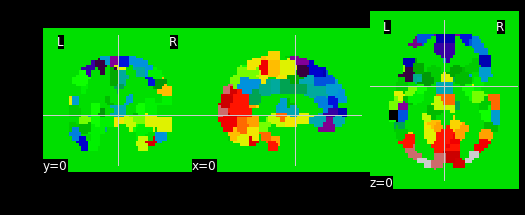

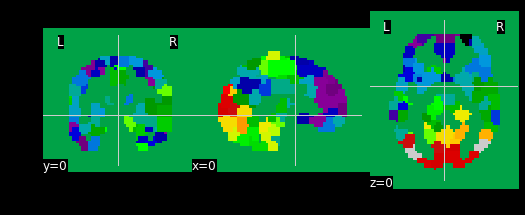

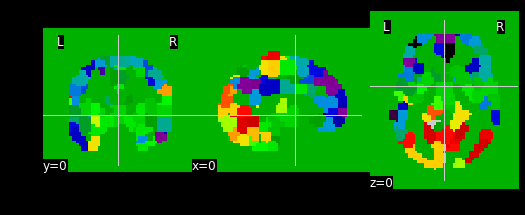

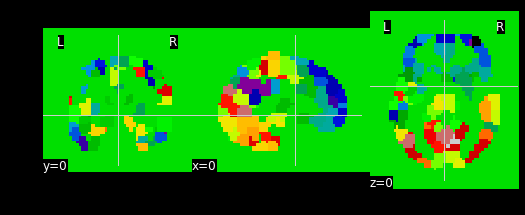

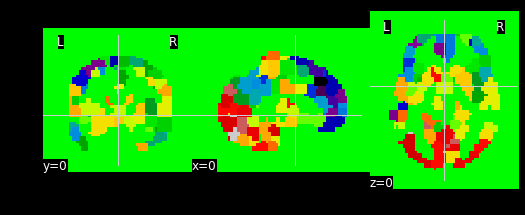

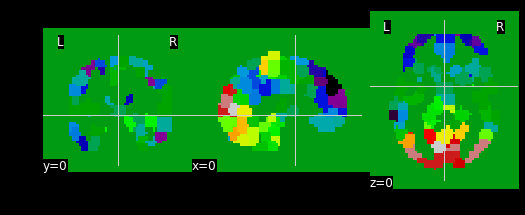

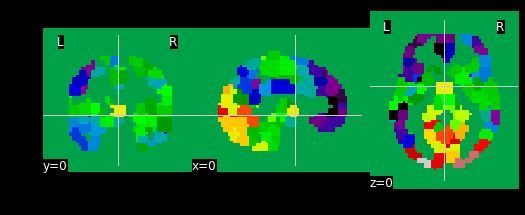

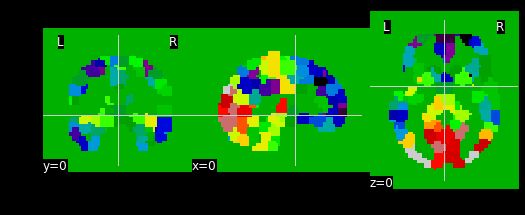

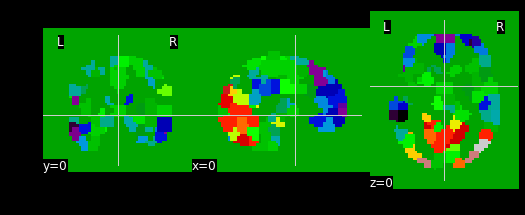

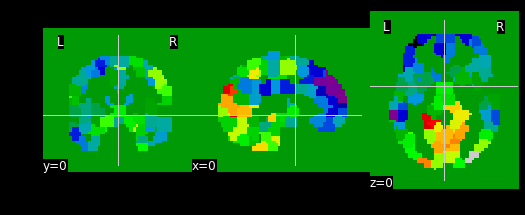

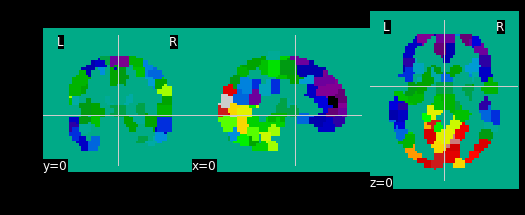

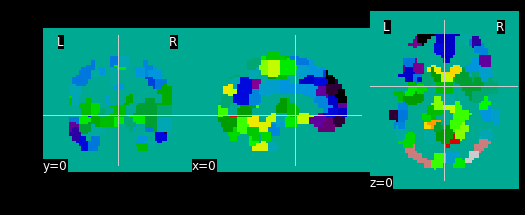

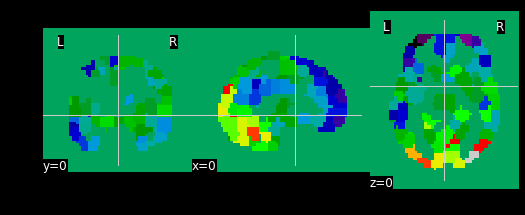

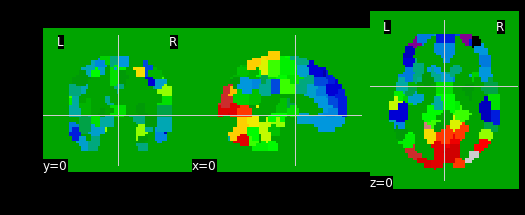

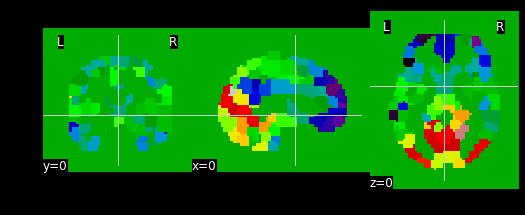

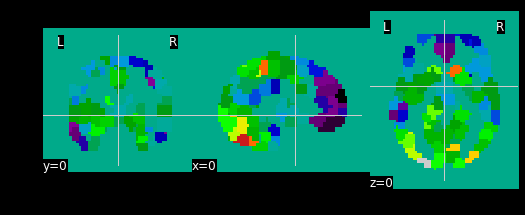

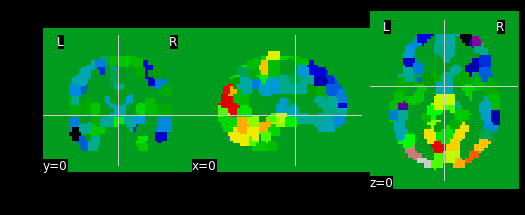

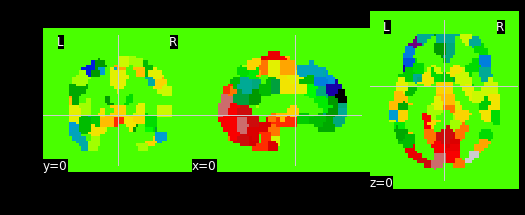

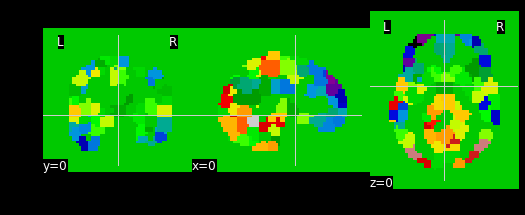

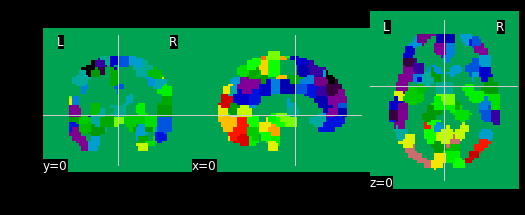

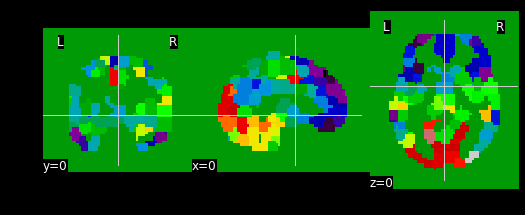

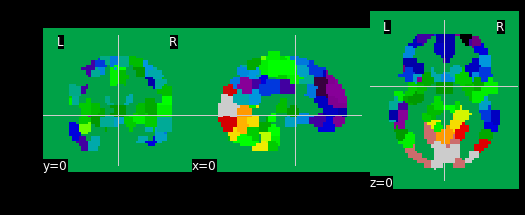

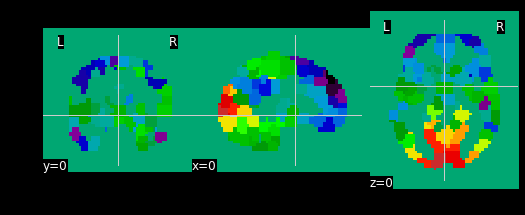

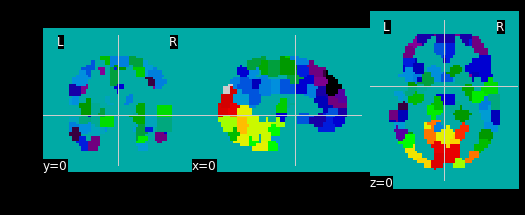

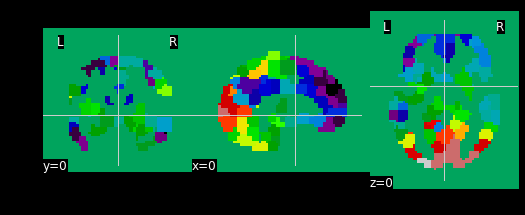

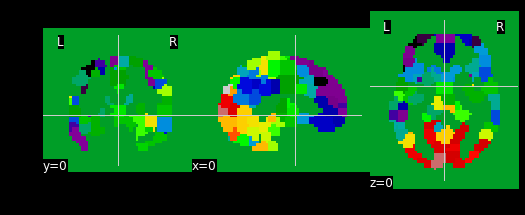

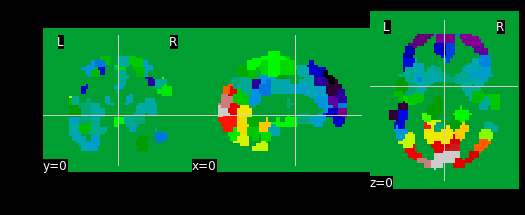

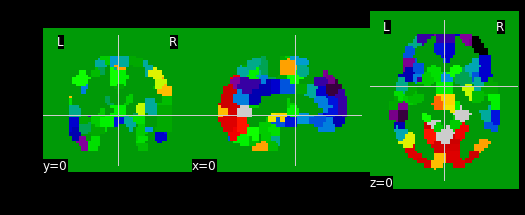

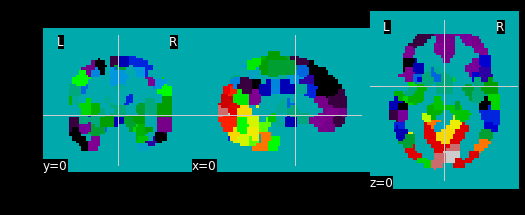

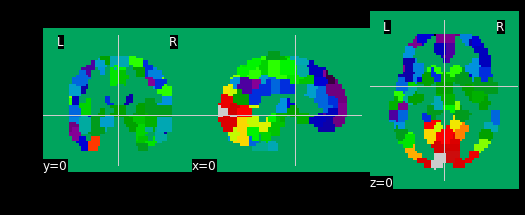

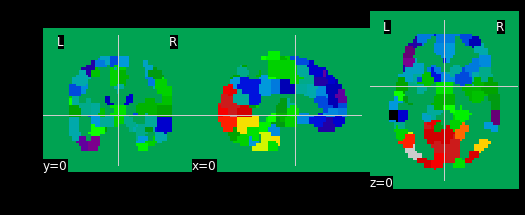

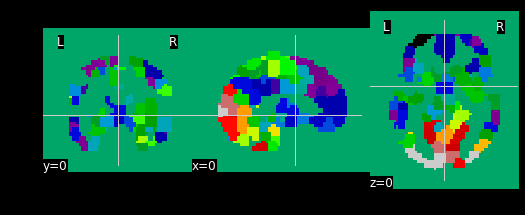

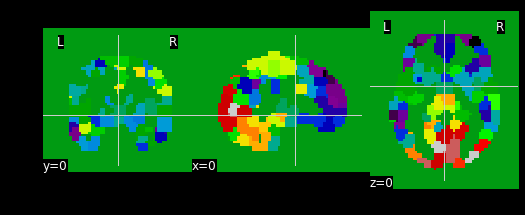

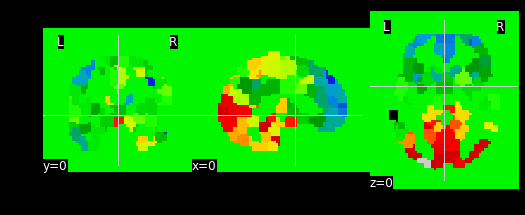

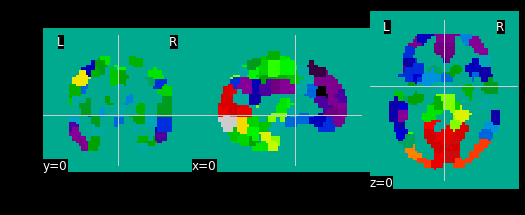

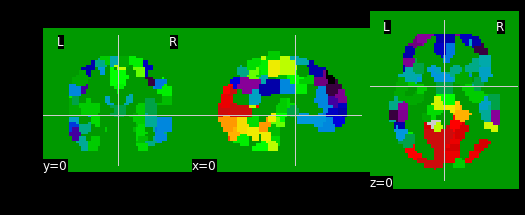

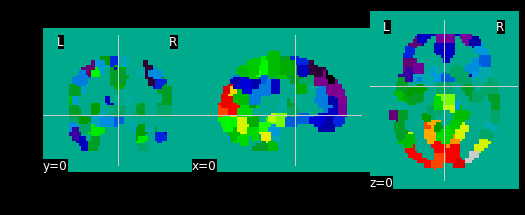

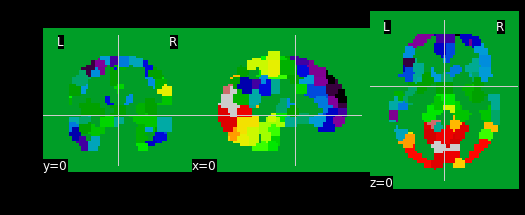

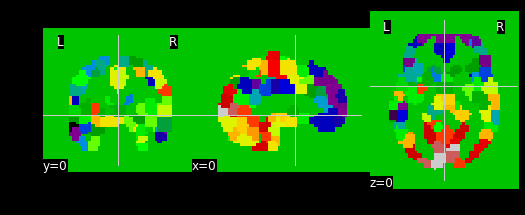

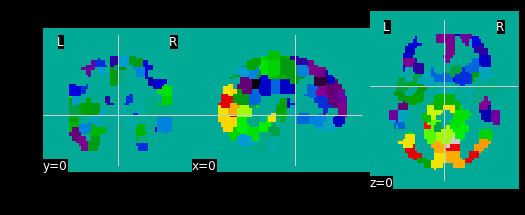

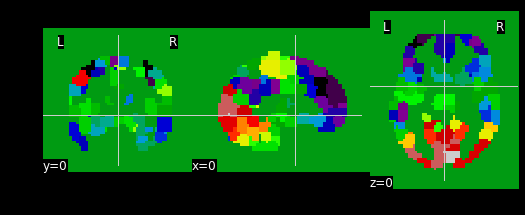

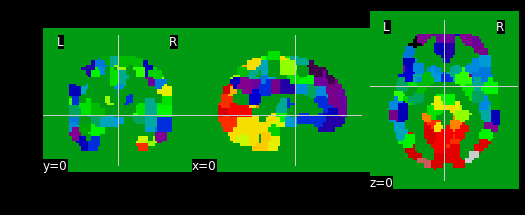

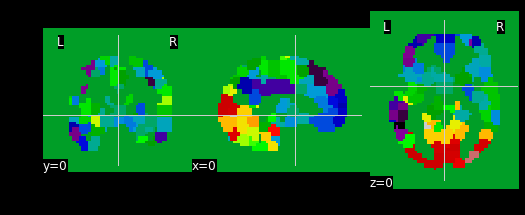

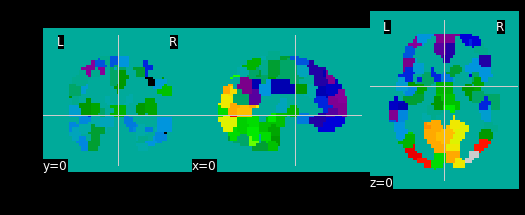

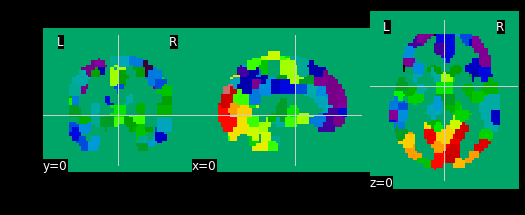

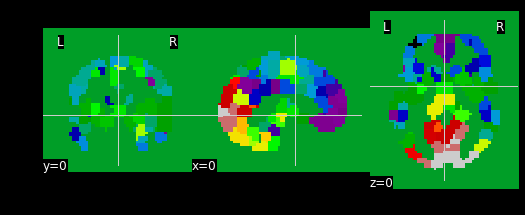

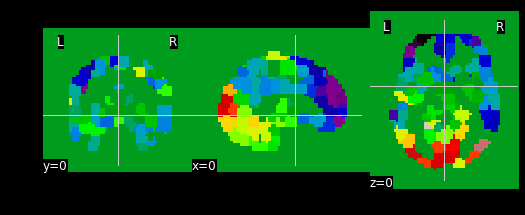

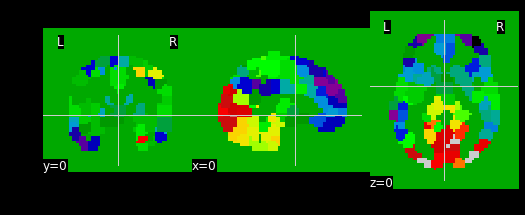

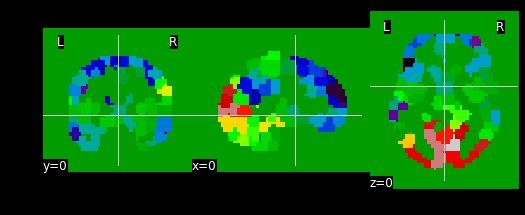

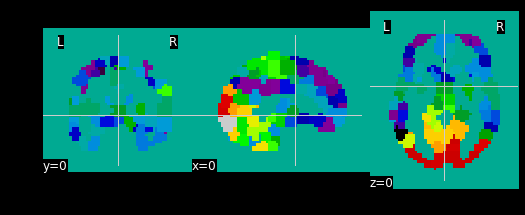

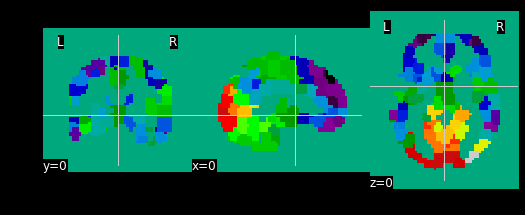

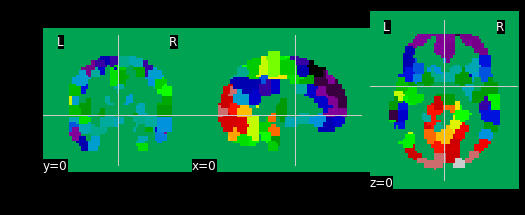

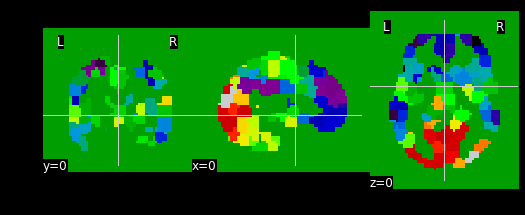

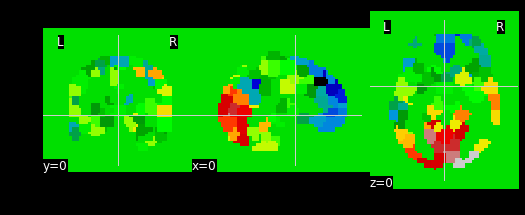

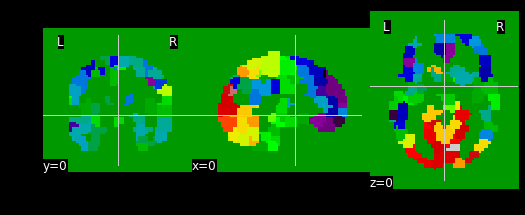

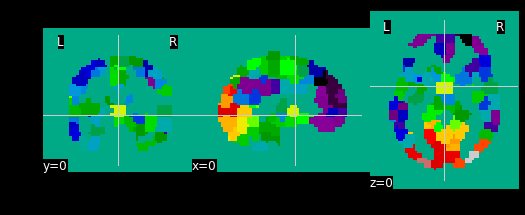

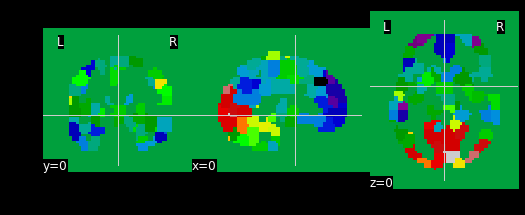

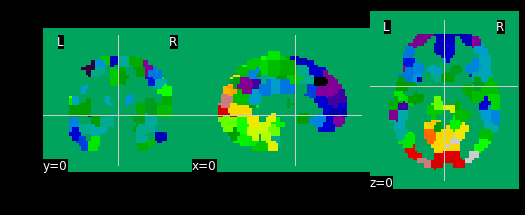

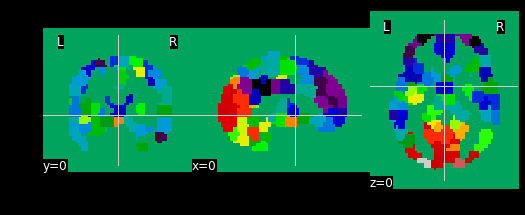

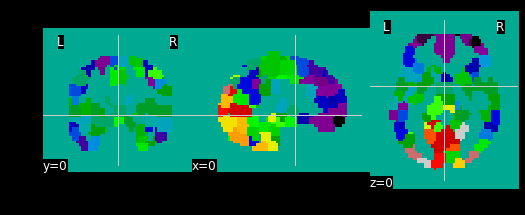

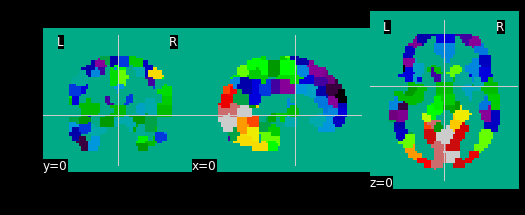

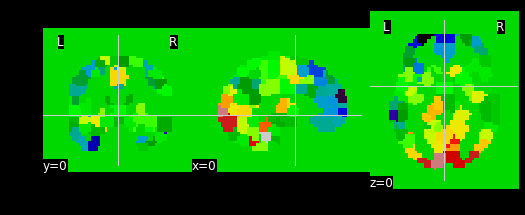

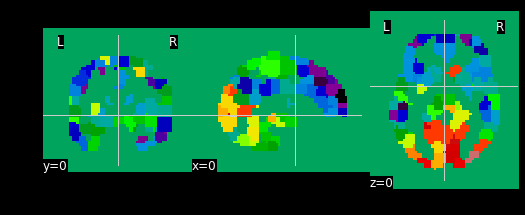

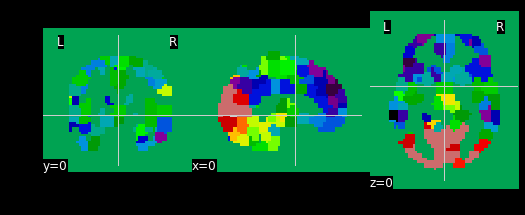

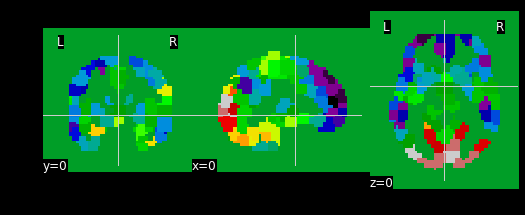

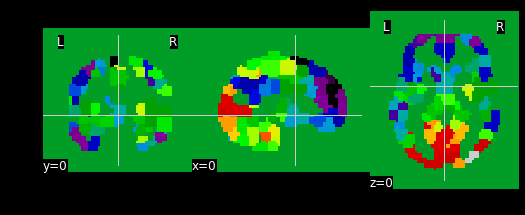

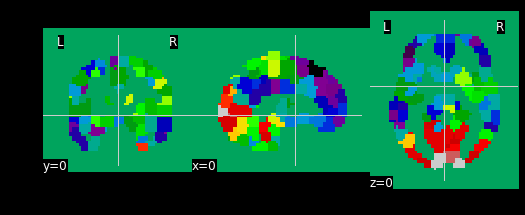

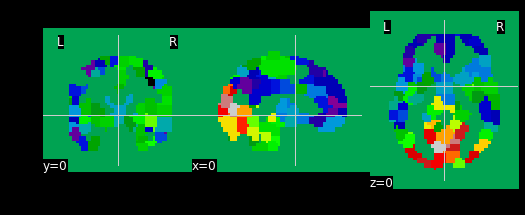

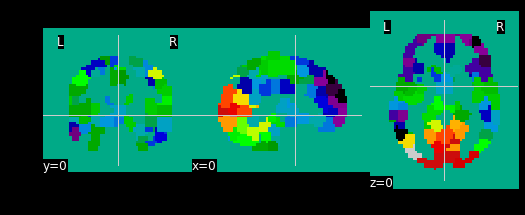

In [3]:
rebuild_nii_individ(0)